In [1]:
import h5py
import numpy as np
import os,random
from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout,BatchNormalization
from tensorflow.keras import layers
import tensorflow.keras.models as Model
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from ctypes import Array
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.metrics import mean_squared_error, accuracy_score
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

In [4]:
def select_for_1024(elements_count,snr):
  sample_select_quotient = int(elements_count/1024)
  sample_selected = 1024*(sample_select_quotient)
  print(f"Total Samples of {snr}: {elements_count}, Sampling Quotient: {sample_select_quotient}, Samples Selected: {sample_selected}")
  return sample_selected,sample_select_quotient

#**Self Generated Dataset QPSK**

In [ ]:


num_symbols = 10240

# x_symbols array will contain complex numbers representing the QPSK symbols. Each symbol will be a complex number with a
#  magnitude of 1 and a phase angle corresponding to one of the four QPSK constellation points (45, 135, 225, or 315 degrees)
x_int = np.random.randint(0, 3, num_symbols) # 0 to 3
x_degrees = x_int*360/4.0 + 45 # 45, 135, 225, 315 degrees
x_radians = x_degrees*np.pi/180.0 # sin() and cos() takes in radians
x_symbols = np.cos(x_radians) + 1j*np.sin(x_radians) # this produces our QPSK complex symbols
n = (np.random.randn(num_symbols) + 1j*np.random.randn(num_symbols))/np.sqrt(2) # AWGN with unity power
r = x_symbols + n * np.sqrt(0.01) # noise power of 0.01
X= np.array([np.real(r),np.imag(r)])
#Reshaped data as per Model expectation (None, 1024, 2)
X= X.reshape(10,1024,2)
Y=np.tile([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],(10240,1))


#**RML2018.10 Dataset**

In [8]:
#Load Data
f = h5py.File('/content/drive/My Drive/Radio-Signal-Classification/Submission/RML2018.01A.Dataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.arange(sample_num)
#X - Signal, Y- Modulations , Z- SNR
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]

for i in range(1,24):
    filename = '/content/drive/My Drive/Radio-Signal-Classification/Submission/RML2018.01A.Dataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    f.close()
print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

<bound method MappingHDF5.keys of <Closed HDF5 file>>


#**RML2016.10A Dataset**

In [37]:
# Load pkl dataset
Xd = pkl.load(open("/content/drive/My Drive/Radio-Signal-Classification/Submission/RML2016.10A.Dataset/RML2016.10a_dict.pkl",'rb'),encoding ='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

X = []
Y = []

for mod in mods:
      sample_Y= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      count=0
      element_1024=[]
      for snr in snrs:
        for count in range(len(Xd[(mod,snr)])):
          # single set of 2,128 samples
          element_2_128 = Xd[(mod,snr)][count]
          # transposed set of 128,2 samples
          element_128_2 = np.transpose(element_2_128)
          # show_shaping_proof(element_2_128,element_128_2)
          #Including samples to array
          element_1024.extend(element_128_2)
      #Divide whole {mod} elements to chunks of 1024
      sample_selected,sample_quotient=select_for_1024(len(element_1024),mod)
      X.append(element_1024[0:sample_selected])
      if mod in classes:
        sample_Y[classes.index(mod)]=1
      elif(mod=='QAM16'):
        sample_Y[23]=1
      elif(mod=='QAM64'):
        sample_Y[18]=1
      #Label data in array of 24 elements form
      Y.append([sample_Y]*sample_quotient)

#Array to list
X = np.vstack(X)
print(X.shape)
sample_selected,sample_quotient=select_for_1024(len(X),"all mods")
X=X.reshape(sample_quotient,1024,2)
Y = np.vstack(Y)
print("X_test:",X.shape)
print("Y_test:",Y.shape)


Total Samples of 8PSK: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of AM-DSB: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of AM-SSB: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of BPSK: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of CPFSK: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of GFSK: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of PAM4: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of QAM16: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of QAM64: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of QPSK: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
Total Samples of WBFM: 2560000, Sampling Quotient: 2500, Samples Selected: 2560000
(28160000, 2)
Total Samples of all mods: 28160000, Sampling Quotient: 27500, Sam

In [ ]:
#func dataset

#**RML2016.10C Dataset**

In [72]:
Xd = pkl.load(open("/content/drive/My Drive/Radio-Signal-Classification/Submission/RML2016.10C.Dataset/2016.04C.multisnr.pkl",'rb'),encoding ='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
classes_11=['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
X = []
Y = []

for mod in classes_11:
      sample_Y= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
      count=0
      element_1024=[]
      for snr in snrs:
        for count in range(len(Xd[(mod,snr)])):
          # single set of 2,128 samples
          element_2_128 = Xd[(mod,snr)][count]
          # transposed set of 128,2 samples
          element_128_2 = np.transpose(element_2_128)
          # show_shaping_proof(element_2_128,element_128_2)
          element_1024.extend(element_128_2)
      sample_selected,sample_quotient=select_for_1024(len(element_1024),mod)
      X.append(element_1024[0:sample_selected])
      if mod in classes:
        sample_Y[classes.index(mod)]=1
      elif(mod=='QAM16'):
        sample_Y[23]=1
      elif(mod=='QAM64'):
        sample_Y[18]=1
      Y.append([sample_Y]*sample_quotient)

X = np.vstack(X)
print(X.shape)
sample_selected,sample_quotient=select_for_1024(len(X),"all mods")
X=X.reshape(sample_quotient,1024,2)
Y = np.vstack(Y)
print("X_test:",X.shape)
print("Y_test:",Y.shape)

Total Samples of 8PSK: 1057280, Sampling Quotient: 1032, Samples Selected: 1056768
Total Samples of AM-DSB: 1804800, Sampling Quotient: 1762, Samples Selected: 1804288
Total Samples of AM-SSB: 1804800, Sampling Quotient: 1762, Samples Selected: 1804288
Total Samples of BPSK: 3192320, Sampling Quotient: 3117, Samples Selected: 3191808
Total Samples of CPFSK: 3192320, Sampling Quotient: 3117, Samples Selected: 3191808
Total Samples of GFSK: 3192320, Sampling Quotient: 3117, Samples Selected: 3191808
Total Samples of PAM4: 1592320, Sampling Quotient: 1555, Samples Selected: 1592320
Total Samples of QAM16: 793600, Sampling Quotient: 775, Samples Selected: 793600
Total Samples of QAM64: 527360, Sampling Quotient: 515, Samples Selected: 527360
Total Samples of QPSK: 1592320, Sampling Quotient: 1555, Samples Selected: 1592320
Total Samples of WBFM: 1994240, Sampling Quotient: 1947, Samples Selected: 1993728
(20740096, 2)
Total Samples of all mods: 20740096, Sampling Quotient: 20254, Samples S

#Define Test Data

In [38]:
n_examples = X.shape[0]
test_idx = list(set(range(0,n_examples))) #Test sample index
X_test =  X[test_idx]  #testing samples
# Y= np.vstack([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]*2500)
Y_test = Y[test_idx]
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0","/gpu:1","/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

X_test: (27500, 1024, 2)
Y_test: (27500, 24)


#Create Dataframe Table and Plot Time Domain IQ

In [70]:
import pandas as pd

X_df = X.reshape(-1, 2048)  # Combine the last two dimensions of X
indices = np.where(Y == 1)
Y_result = np.take(classes, indices[1])

# Create a DataFrame to tabulate the data
data = {'I': X_df[indices[0]][:, 0],  # Assuming X has 2 dimensions
        'Q': X_df[indices[0]][:, 1],  # Assuming X has 2 dimensions
        'Modulation': Y_result,
        'SNR': np.concatenate(Z)}
df = pd.DataFrame(data)


# Display the tabulated data
print(df)



               I           Q Modulation
0      24.714563  -48.443947       8PSK
1     -58.670315  101.670601       8PSK
2      77.299454 -137.867615       8PSK
3    -200.706985  135.773819       8PSK
4     -49.589848  -18.773249       8PSK
...          ...         ...        ...
6989   -1.181181    1.457813       QPSK
6990    1.430330    2.052875       QPSK
6991    1.707176    2.200639       QPSK
6992   -0.966788   -0.928703       QPSK
6993   -1.094241    1.152349       QPSK

[6994 rows x 3 columns]


In [71]:
from scipy.signal import spectrogram
fig = plt.figure(figsize=(20, 16), dpi=80)
SNR=30
clas="32PSK"

# ADD SNR,SHOW NOISY
for clas in classes[0:24]:
    row=df[(df['Modulation'] == clas) & (df['SNR'] == SNR)]
    plt.subplot(6, 4, classes.index(clas)+1)
    plt.plot(row['I'],color='green', label='I component')
    plt.plot(row['Q'],color='salmon', label='Q component')
    plt.title(f'IQ Plot -,{clas},{SNR}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.tight_layout(pad=1.7)



KeyError: 'SNR'

<Figure size 1600x1280 with 0 Axes>

# Data Confusion Matrix and Accuracy Graph


In [8]:
# Plot confusion matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Predict Model
model = Model.load_model('/content/drive/My Drive/Radio-Signal-Classification/Submission/Model_Files/model_full_SNR.h5')
print(model.input)
print(model.output)
Y_pred = model.predict(X_test, batch_size=1024)

KerasTensor(type_spec=TensorSpec(shape=(None, 1024, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 24), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")
24/27 [=========================>....] - ETA: 9s 

(2, 24)
[[9.99998689e-01 5.99331891e-13 5.88755661e-15 2.26661808e-16
  5.74644181e-20 1.56860454e-15 4.27067473e-14 1.14503676e-13
  1.69047692e-17 3.00793299e-13 2.11274029e-20 9.88092788e-22
  2.15647088e-23 2.30920968e-22 1.02856715e-22 6.05857103e-23
  1.39627471e-22 1.04256728e-14 4.07402201e-16 5.71905673e-07
  7.04609533e-07 1.87426533e-18 1.01283719e-14 2.77075886e-16]
 [9.99998450e-01 6.10222972e-13 6.22058540e-15 2.60708006e-16
  7.22458061e-20 1.77858051e-15 4.85275611e-14 1.29614567e-13
  1.92830293e-17 3.41404232e-13 2.46260102e-20 1.11786311e-21
  2.47416977e-23 2.61105311e-22 1.16874691e-22 7.12377811e-23
  1.58508005e-22 1.15206357e-14 4.54160590e-16 6.61564570e-07
  7.88766783e-07 2.20471158e-18 1.18286677e-14 3.19691860e-16]]


<ipython-input-34-b34623ffa2b2>:10: RuntimeWarning: invalid value encountered in divide
  confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])


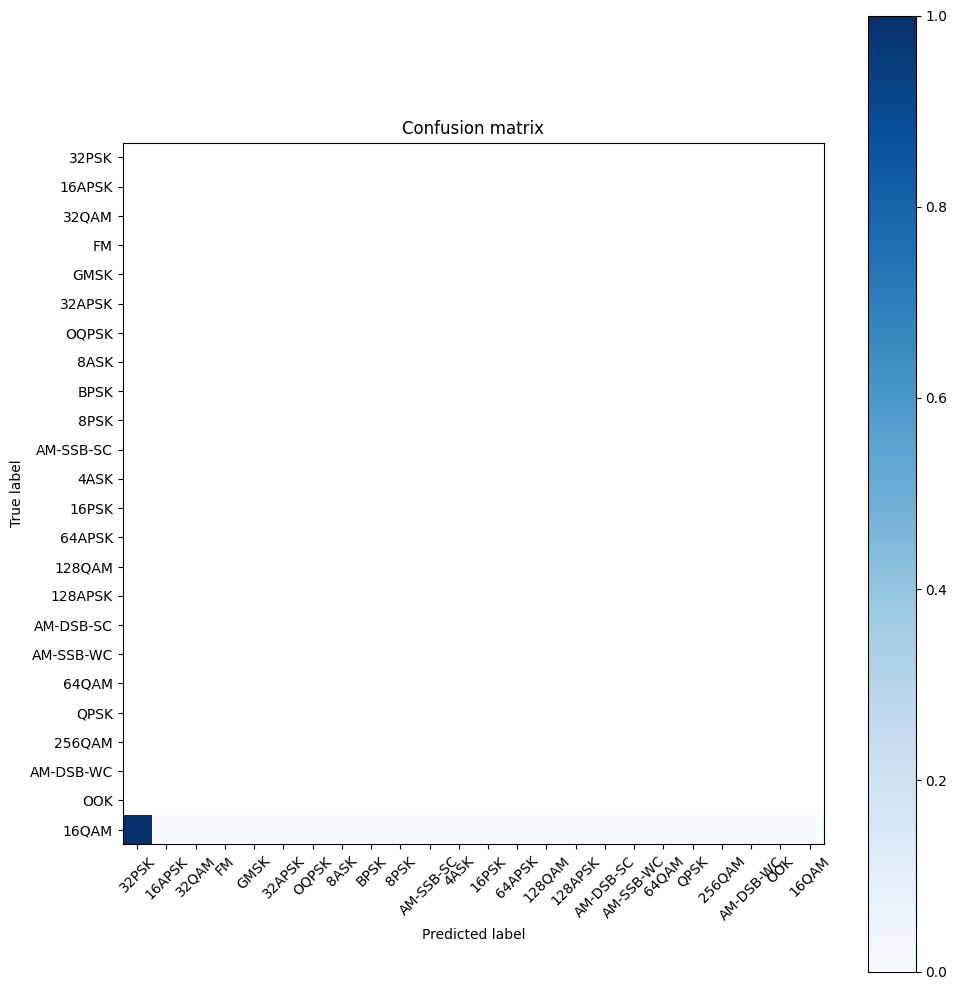

In [34]:
print(Y_pred.shape)
print(Y_pred)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    k = int(np.argmax(Y_pred[i,:]))
    j = list(Y_test[i,:]).index(1) if 1 in list(Y_test[i,:]) else k
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)